<h1 align='center'>Image and Video Processing</h1>
<h1 align='center'>Assignment 6</h1>
<h2 align='center'>Pushkal Mishra</h2>
<h2 align='center'>EE20BTECH11042</h2>

# Table of Contents
- [Importing Libraries](#1)
- [Importing Images](#2)
- [Question 1 - Motion Estimation](#3)
    - [Divide image into non-overlapping macro blocks](#4)
    - [Mean Absolute Distance](#5)
    - [Search Process](#6)
        - [Helper functions](#7)
        - [Step 1: Search at 8 location  $\pm$4 pixels](#8)
        - [Step 2: Search at 8 location  $\pm$2 pixels](#9)
        - [Step 3: Search at 8 location  $\pm$1 pixels](#10)
    - [Plotting Motion vector of each block](#11)
    - [Generating motion compensated predicted frame](#12)
    - [Computing error between frames](#13)
        - [Mean Squared Error (MSE)](#14)
        - [Structural Similarity Index (SSIM)](#15)

<a name = '1'></a>
# Importing Libraries

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

<a name = '2'></a>
# Importing Images

In [2]:
first_frame = np.array(Image.open('first_frame.png').convert("L"), dtype = int)
second_frame = np.array(Image.open('second_frame.png').convert("L"), dtype = int)

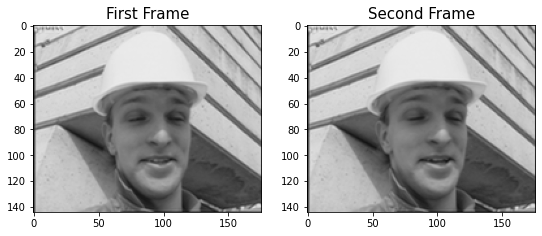

In [3]:
fig = plt.figure(figsize = (9, 4))

plt.subplot(1, 2, 1)
plt.imshow(first_frame, cmap = 'gray')
plt.title("First Frame", size = 15)

plt.subplot(1, 2, 2)
plt.imshow(second_frame, cmap = 'gray')
plt.title("Second Frame", size = 15)

plt.show()

In [4]:
image_shape = first_frame.shape
print(f"Shape of the image: {image_shape}")

Shape of the image: (144, 176)


<a name = '3'></a>
# Question 1 - Motion Estimation

## Divide image into non-overlapping macro blocks<a name = '4'></a>

In [5]:
def divide_macro_blocks(image, block_shape):
    M, N = image.shape
    m, n = block_shape
    m_2, n_2 = int(m / 2), int(n / 2)
    x, y = int(M / m), int(N / n)
    macro_blocks = []
    
    for i in range(x):
        for j in range(y):
            i1, j1 = i * m, j * n
            macro_blocks.append([[i1 + m_2, j1 + n_2], image[i1 : i1 + m, j1 : j1 + n].reshape(block_shape)])
    
    return macro_blocks

## Mean Absolute Distance<a name = '5'></a>

In [6]:
def compute_mad(image1, image2):
    M, N = image1.shape
    return np.sum(np.abs((image1 - image2))) / (M * N)

## Search Process<a name = '6'></a>

### Helper functions<a name = '7'></a>

In [7]:
def give_search_positions(image_shape, pixel_search, block_position, block_shape):
    M, N = image_shape
    x, y = pixel_search, pixel_search
    search_possibilities = [[0, 0], [-x, 0], [-x, y], [0, y], [x, y], [x, 0], [x, -y], [0, -y], [-x, -y]]
    i, j = block_position
    m, n = int(block_shape[0] / 2), int(block_shape[1] / 2)
    search_spaces = []
    for sp in search_possibilities:
        x1, y1 = sp
        i1, j1 = i + x1, j + y1
        if i1 >= m and i1 <= (M - m) and j1 >= n and j1 <= (N - n):
            search_spaces.append(sp)
    return search_spaces
    
def give_best_position(macro_blocks, frame, pixel_search, block_shape):
    M, N = frame.shape
    m, n = block_shape
    m_2, n_2 = int(m / 2), int(n / 2)
    x, y = int(M / m), int(N / n)
    coordinates = []
    
    for block in macro_blocks:
        center_position, image_block = block
        i1, j1 = center_position
        search_positions = give_search_positions([M, N], pixel_search, center_position, block_shape)

        tmp_mad = np.inf
        best_search_position = []
        
        for sp in search_positions:
            x1, y1 = sp
            i_sp, j_sp = i1 + x1, j1 + y1
            mad = compute_mad(image_block, frame[i_sp - m_2 : i_sp + m_2, j_sp - n_2 : j_sp + n_2])
            if mad < tmp_mad:
                tmp_mad = mad
                best_search_position = [i_sp, j_sp]
        
        coordinates.append([best_search_position, image_block])
    
    return coordinates

### Step 1: Search at 8 location  $\pm$4 pixels<a name = '8'></a>

In [8]:
second_frame_blocks = divide_macro_blocks(second_frame, [16, 16])
step1_blocks = give_best_position(second_frame_blocks, first_frame, 4, [16, 16])

### Step 2: Search at 8 location  $\pm$2 pixels<a name = '9'></a>

In [9]:
step2_blocks = give_best_position(step1_blocks, first_frame, 2, [16, 16])

### Step 3: Search at 8 location  $\pm$1 pixels<a name = '10'></a>

In [10]:
step3_blocks = give_best_position(step2_blocks, first_frame, 1, [16, 16])

## Plotting Motion vector of each block<a name = '11'></a>

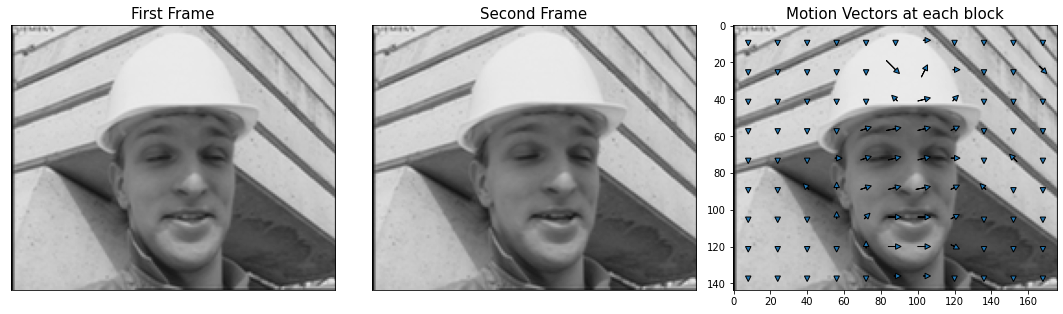

In [11]:
fig = plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
plt.imshow(first_frame, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("First Frame", size = 15)

plt.subplot(1, 3, 2)
plt.imshow(second_frame, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Second Frame", size = 15)

plt.subplot(1, 3, 3)
plt.imshow(first_frame, cmap = 'gray')
for i, block in enumerate(zip(second_frame_blocks, step3_blocks)):
    pos_k1 = block[0][0]
    pos_k = block[1][0]
    dx, dy = pos_k1[0] - pos_k[0], pos_k1[1] - pos_k[1]

    plt.arrow(pos_k[1], pos_k[0], dy, dx, head_width = 3, head_length = 3, length_includes_head = False)
plt.title("Motion Vectors at each block", size = 15)

# plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Generating motion compensated predicted frame<a name = '12'></a>

In [12]:
def predict_frame(final_blocks, first_image, block_shape):
    M, N = first_image.shape
    m, n = block_shape
    m_2, n_2 = int(m / 2), int(n / 2)
    x, y = int(M / m), int(N / n)
    new_image = np.zeros([M, N])
    
    tmp = 0
    for i in range(x):
        for j in range(y):
            i1, j1 = i * m, j * n
            position, _ = final_blocks[tmp]
            x1, y1 = position
            new_image[i1 : i1 + m, j1 : j1 + n] = first_image[x1 - m_2 : x1 + m_2, y1 - n_2 : y1 + n_2]
            tmp += 1
    
    return new_image

In [13]:
predicted_frame = predict_frame(step3_blocks, first_frame, [16, 16])

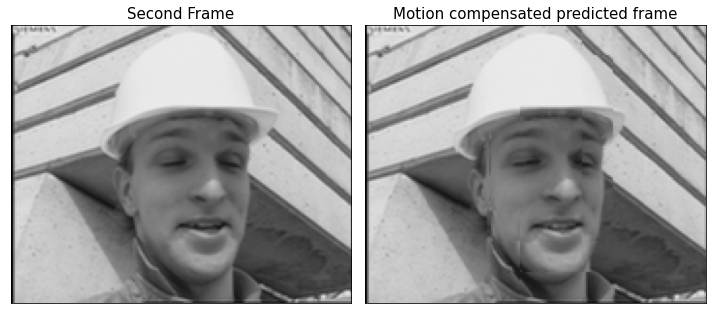

In [14]:
fig = plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(second_frame, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Second Frame", size = 15)

plt.subplot(1, 2, 2)
plt.imshow(predicted_frame, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Motion compensated predicted frame", size = 15)

plt.tight_layout()
plt.show()

## Computing error between frames<a name = '13'></a>

### Mean Squared Error (MSE)<a name = '14'></a>

In [15]:
def compute_mse(image1, image2):
    image1 = image1.astype(float)
    image2 = image2.astype(float)
    return np.average(((image1 - image2) ** 2).flatten())

### Structural Similarity Index (SSIM)<a name = '15'></a>

In [16]:
def generateGaussianWindow(size, sigma):
    P, Q = size
    window = np.zeros([P, Q])
    p1, q1 = int((P - 1) / 2), int((Q - 1) / 2)
    sigma2 = sigma ** 2
    
    for i in range(P):
        for j in range(Q):
            window[i, j] = np.exp(-((i - p1) ** 2 + (j - q1) ** 2) / (2 * sigma2))
    
    window = window / np.sum(window)
    return window

def PadForSSIM(image, filter_shape):
    P, Q = filter_shape
    M, N = image.shape
    padded_image = np.zeros([M + P - 1, N + Q - 1])
    P2, Q2 = int((P - 1) / 2), int((Q - 1) / 2)
    
    padded_image[P2 : P2 + M, Q2 :  Q2 + N] = image

    for i in range(P2):
        padded_image[i, Q2 :  Q2 + N] = image[P2 - i - 1, :]
        padded_image[i + M + P2, Q2 :  Q2 + N] = image[-1 - i , :]
    for i in range(Q2):
        padded_image[P2 : P2 + M, i] = image[:, Q2 - i - 1]
        padded_image[P2 : P2 + M, i + N + Q2] = image[:, -1 - i] 
        
    padded_image[ : P2, : Q2] = image[0, 0]
    padded_image[ : P2, Q2 + N : ] = image[0, -1]
    padded_image[P2 + M : , : Q2] = image[-1, 0]
    padded_image[P2 + M : , Q2 + N : ] = image[-1, -1]
    
    return padded_image
    
def calculateSSIMIndex(window_size, sigma, image1, image2):
    
    M, N = image1.shape
    m, n = window_size
    gaussian_window = generateGaussianWindow(window_size, sigma)
    padded_image1 = PadForSSIM(image1, window_size)
    padded_image2 = PadForSSIM(image2, window_size)
    
    mu_1 = np.zeros(image1.shape)
    mu_2 = np.zeros(image2.shape)
    
    sigma_1 = np.zeros(image1.shape)
    sigma_2 = np.zeros(image2.shape)
    
    sigma_12 = np.zeros(image1.shape)
    
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2
    C3 = C2 / 2
    
    L = np.zeros(image1.shape)
    C = np.zeros(image1.shape)
    S = np.zeros(image1.shape)
    
    for i in range(M):
        for j in range(N):
            mu_1[i, j] = np.sum(gaussian_window * padded_image1[i : i + m, j : j + n])
            mu_2[i, j] = np.sum(gaussian_window * padded_image2[i : i + m, j : j + n])
    
            sigma_1[i, j] = np.sqrt(np.sum(gaussian_window * (padded_image1[i : i + m, j : j + n] - mu_1[i, j]) ** 2))
            sigma_2[i, j] = np.sqrt(np.sum(gaussian_window * (padded_image2[i : i + m, j : j + n] - mu_2[i, j]) ** 2))
    
            sigma_12[i, j] = np.sum(gaussian_window * (padded_image1[i : i + m, j : j + n] - mu_1[i, j]) * (padded_image2[i : i + m, j : j + n] - mu_2[i, j]))
    
            L[i, j] = (2 * mu_1[i, j] * mu_2[i, j] + C1) / (mu_1[i, j] ** 2 + mu_2[i, j] ** 2 + C1)
            C[i, j] = (2 * sigma_1[i, j] * sigma_2[i, j] + C2) / (sigma_1[i, j] ** 2 + sigma_2[i, j] ** 2 + C2)
            S[i, j] = (sigma_12[i, j] + C3) / (sigma_1[i, j] * sigma_2[i, j] + C3)
    
    SSIM = L * C * S
    MSSIM = np.around(np.average(SSIM), 6)

    return MSSIM, SSIM

In [17]:
mse_images = compute_mse(second_frame, predicted_frame)
print(f"Mean Squared Error between images: {mse_images:.6f}")

mean_SSIM, SSIM = calculateSSIMIndex([11, 11], 1, second_frame, predicted_frame)
print(f"Mean SSIM score between images: {mean_SSIM}")

Mean Squared Error between images: 31.156408
Mean SSIM score between images: 0.950099


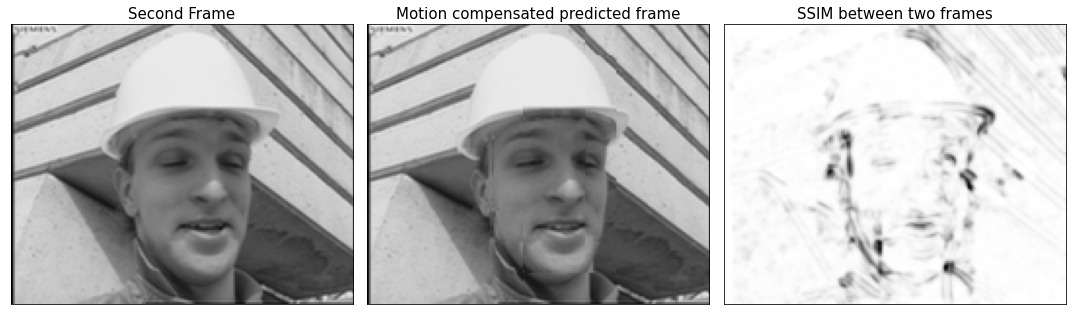

In [18]:
fig = plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
plt.imshow(second_frame, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Second Frame", size = 15)

plt.subplot(1, 3, 2)
plt.imshow(predicted_frame, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Motion compensated predicted frame", size = 15)

plt.subplot(1, 3, 3)
plt.imshow(SSIM, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("SSIM between two frames", size = 15)

plt.tight_layout()
plt.show()